![Logo da Ilum]("Logos_Ilum-CNPEM.png")

## <center> Trabalho Final

## Como descrever estatisticamente a formação de estruturas em larga escala no universo?
    
<b> Disciplina: </b> Fundamentos Estatísiticos da Termodinâmica <br>
<b> Professor: </b> Felipe Crasto de Lima <br>
<b> Semestre: </b> 2025.2 <br>
<b> Alunos: </b> Gabriel Martins Sousa, Letícia Almeida Nunes, Rafaela Beatriz Silva Luz e Yasmin Barbosa Shimizu<br>

A fim de entender a dinâmica dos corpos no universo, regida principalmente pela força gravitacional, foi realizada a simulação estatística de muitos corpos em um espaço, considerando as forças de atração e repulsão entre eles. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D 

In [8]:
def desloc_min_image(rij_vec, L):
    return rij_vec - L * np.rint(rij_vec / L)

def potencial_par(r, A, eps, sigma):
    if r <= 0.0:
        return 1e6
        
    U_grav = -1.0 / (r + A)
    r_cut = 2**(1/6) * sigma
    if r < r_cut:
        sr6 = (sigma / r)**6
        U_LJ = 4.0 * eps * (sr6**2 - sr6) + eps
    else:
        U_LJ = 0.0
    return U_grav + U_LJ

def energia_potencial(positions, L, A, eps, sigma):
    N = positions.shape[0]
    U_total = 0.0

    for i in range(N):
        ri = positions[i]
        for j in range(i + 1, N):
            rj = positions[j]
            rij_vec = ri - rj
            rij_vec = desloc_min_image(rij_vec, L)
            rij = np.linalg.norm(rij_vec)
            U_total += potencial_par(rij, A, eps, sigma)

    return U_total

def distancia_media(positions, L):
    N = positions.shape[0]
    soma_r = 0.0
    soma_r2 = 0.0
    count = 0
    for i in range(N - 1):
        for j in range(i + 1, N):
            rij_vec = positions[i] - positions[j]
            rij_vec = desloc_min_image(rij_vec, L)
            rij = np.linalg.norm(rij_vec)
            soma_r += rij
            count += 1
    return soma_r / count

def passo_metro_grav(positions, L, eta, passo, A, eps, sigma):
    N = positions.shape[0]
    for _ in range(N):
        i = np.random.randint(0, N)
        pos_old = positions[i].copy()

        # energia antiga (interação de i com todos os outros) com MIC
        U_old = 0.0
        for j in range(N):
            if j == i:
                continue
            rij_vec = pos_old - positions[j]
            rij_vec = desloc_min_image(rij_vec, L)
            rij = np.linalg.norm(rij_vec)
            U_old += potencial_par(rij, A, eps, sigma)

        desloc = (np.random.rand(3) - 0.5) * 2 * passo * L
        pos_new = np.mod(pos_old + desloc, L)

        U_new = 0.0
        for j in range(N):
            if j == i:
                continue
            rij_vec = pos_new - positions[j]
            rij_vec = desloc_min_image(rij_vec, L)
            rij = np.linalg.norm(rij_vec)
            U_new += potencial_par(rij, A, eps, sigma)

        dU = U_new - U_old

        if dU < 0 or np.random.rand() < np.exp(-eta * dU):
            positions[i] = pos_new

    return positions


def simular_gas_gravitante(N, L, eta, T, n_passos, passo, A, eps, sigma):
    positions = np.random.rand(N, 3) * L
    rho = N / L**3

    energias = []
    dist_medias = []
    dist2_medias = []

    for passo_mc in range(n_passos):
        positions = passo_metro_grav(positions, L, eta, passo, A, eps, sigma)

        U = energia_potencial(positions, L, A, eps, sigma)
        r_med = distancia_media(positions, L)

        energias.append(U)
        dist_medias.append(r_med)

    U_med = np.mean(energias)
    r_med = np.mean(dist_medias)
    #U_final = energias[-1]
    #r_final = dist_medias[-1]
   
    P = rho * T + (1.0 / (3 * L**3)) * U_med

    resultados = {
        "energia_media": U_med,
        "distancia_media": r_med,
        "pressao": P
    }

    return resultados, positions

In [9]:
etas = np.linspace(0.5, 5.0, 10)

N = 200
L = 1.0
T = 1
n_passos = 400
passo = 0.5
A = 1e-2
eps = 1.0
sigma = 0.1

energias = []
flut_energias = []
densidades = []
dist_medias = []
dist2_medias = []
pressoes = []

In [4]:
for eta in etas:
    print(f"Simulando para η = {eta:.2f} ...")
    resultados, posicoes = simular_gas_gravitante(N, L, eta, T, n_passos, passo, A, eps, sigma)
    energias.append(resultados["energia_media"])
    dist_medias.append(resultados["distancia_media"])
    pressoes.append(resultados["pressao"])

Simulando para η = 0.50 ...
Simulando para η = 1.00 ...


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(etas, energias, 'o-', lw=2)
plt.xlabel(r'$\eta$')
plt.ylabel('Energia média')
plt.title('Energia potencial média')

plt.subplot(1, 3, 2)
plt.plot(etas, pressoes, 'o-', lw=2, color='green')
plt.xlabel(r'$\eta$')
plt.ylabel('Pressão')
plt.title('Pressão')

plt.subplot(1, 3, 3)
plt.plot(etas, dist_medias, 'o-', lw=2, color='red')
plt.xlabel(r'$\eta$')
plt.ylabel('Distância média ⟨r⟩')
plt.title('Distância média entre partículas')

plt.tight_layout()
plt.savefig("Gráficos da Simulação de MC.png", dpi=500)
plt.show()

In [10]:
eta = 1.5
N = 200
resultados, posicoes = simular_gas_gravitante(N, L, eta, T, n_passos, passo, A, eps, sigma)

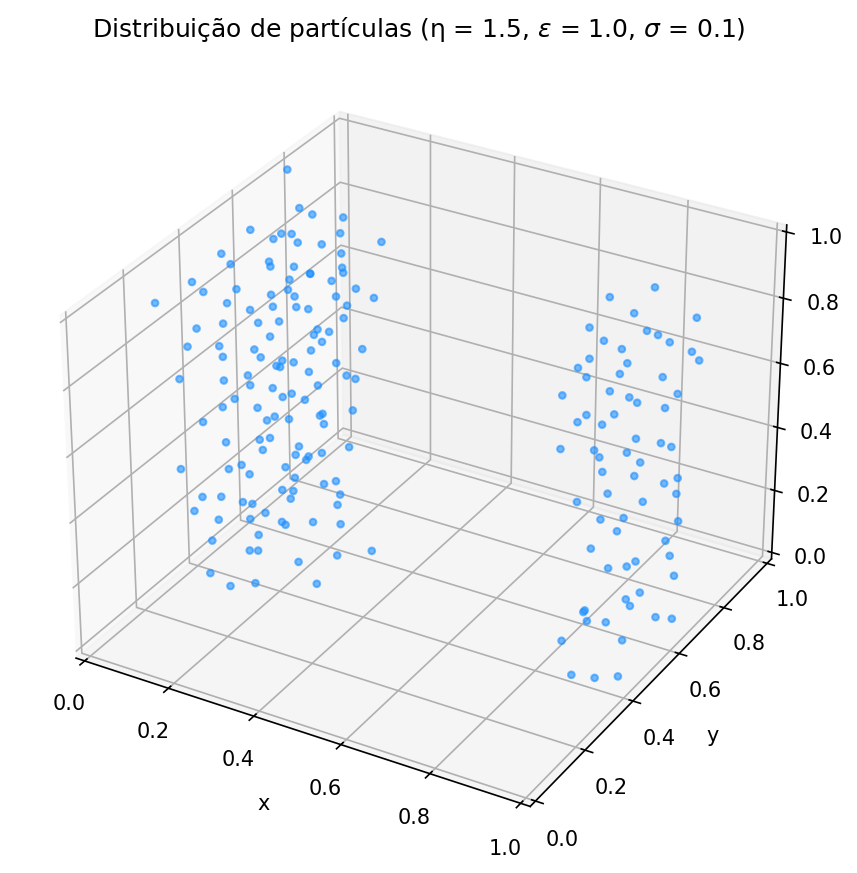

In [11]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(7, 7), dpi=150)
ax = fig.add_subplot(111, projection='3d')

x = posicoes[:, 0]
y = posicoes[:, 1]
z = posicoes[:, 2]

ax.scatter(x, y, z, s=10, color='dodgerblue', alpha=0.6)

L = 1.0
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f'Distribuição de partículas (η = 1.5, $\epsilon$ = 1.0, $\sigma$ = 0.1)')

plt.savefig("Distribuição do gás autogravitante 4.png", bbox_inches='tight', dpi=500)
plt.show()